In [1]:
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

2023-08-15 16:17:18.092888: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 16:17:18.874913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_dir = '/home/jhr/Documents/data/mov/dataset/'
# data_dir = '../data/mov/dataset/'
data_root = pathlib.Path(data_dir)

In [3]:
for item in data_root.iterdir():
    print(item)

/home/jhr/Documents/data/mov/dataset/black_jeans
/home/jhr/Documents/data/mov/dataset/blue_shirt
/home/jhr/Documents/data/mov/dataset/red_shirt
/home/jhr/Documents/data/mov/dataset/black_shoes
/home/jhr/Documents/data/mov/dataset/red_dress
/home/jhr/Documents/data/mov/dataset/blue_dress
/home/jhr/Documents/data/mov/dataset/blue_jeans


In [4]:
all_image_paths = list(data_root.glob('*/*'))
image_count = len(all_image_paths)
image_count

2525

In [5]:
all_image_paths[:3]

[PosixPath('/home/jhr/Documents/data/mov/dataset/black_jeans/00000120.jpg'),
 PosixPath('/home/jhr/Documents/data/mov/dataset/black_jeans/00000239.jpg'),
 PosixPath('/home/jhr/Documents/data/mov/dataset/black_jeans/00000146.jpg')]

In [6]:
# 乱序
import random
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

In [7]:
all_image_paths[:5]

['/home/jhr/Documents/data/mov/dataset/red_shirt/00000156.jpg',
 '/home/jhr/Documents/data/mov/dataset/red_dress/00000238.jpg',
 '/home/jhr/Documents/data/mov/dataset/red_shirt/00000030.png',
 '/home/jhr/Documents/data/mov/dataset/blue_shirt/00000353.jpg',
 '/home/jhr/Documents/data/mov/dataset/red_shirt/00000182.jpg']

In [8]:
# 提取上级目录
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['black_jeans',
 'black_shoes',
 'blue_dress',
 'blue_jeans',
 'blue_shirt',
 'red_dress',
 'red_shirt']

In [9]:
# 提取label1
color_label_names = set(name.split('_')[0] for name in label_names)
color_label_names

{'black', 'blue', 'red'}

In [10]:
# 提取label2
item_label_names = set(name.split('_')[1] for name in label_names)
item_label_names

{'dress', 'jeans', 'shirt', 'shoes'}

### 对label进行编码

In [11]:
color_label_to_index = dict((name, index)for index, name in enumerate(color_label_names))
color_label_to_index

{'red': 0, 'blue': 1, 'black': 2}

In [12]:
item_label_to_index = dict((name, index)for index, name in enumerate(item_label_names))
item_label_to_index

{'shirt': 0, 'dress': 1, 'shoes': 2, 'jeans': 3}

In [13]:
all_image_labels = [pathlib.Path(path).parent.name for path in all_image_paths]
all_image_labels[:5]

['red_shirt', 'red_dress', 'red_shirt', 'blue_shirt', 'red_shirt']

In [14]:
#颜色编码
color_labels = [color_label_to_index[label.split('_')[0]] for label in all_image_labels]
color_labels[:5]

[0, 0, 0, 1, 0]

In [15]:
#种类编码
item_labels = [item_label_to_index[label.split('_')[1]] for label in all_image_labels]
item_labels[:5]

[0, 1, 0, 0, 0]

---

In [16]:
from IPython import display

In [17]:
# for n in range(3):
#     image_index = random.choice(range(len(all_image_paths)))
#     display.display(display.Image(
#         all_image_paths[image_index], width=1, height=1))
#     print(all_image_labels[image_index])
#     print()

**对单张图片进行预处理**

In [18]:
img_path = all_image_paths[1]
img_path

'/home/jhr/Documents/data/mov/dataset/red_dress/00000238.jpg'

In [19]:
img_raw = tf.io.read_file(img_path)

2023-08-15 16:17:21.438112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9583 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
2023-08-15 16:17:21.438964: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9625 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:61:00.0, compute capability: 7.5


In [20]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(1104, 736, 3)
<dtype: 'uint8'>


In [21]:
img_tensor = tf.cast(img_tensor, tf.float32)
img_tensor = tf.image.resize(img_tensor, [224, 224])
img_tensor = img_tensor/255.0
print(img_tensor.shape)

(224, 224, 3)


In [22]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = image/255.0
    image = 2*image-1
    return image

Text(0.5, 0, 'red_shirt')

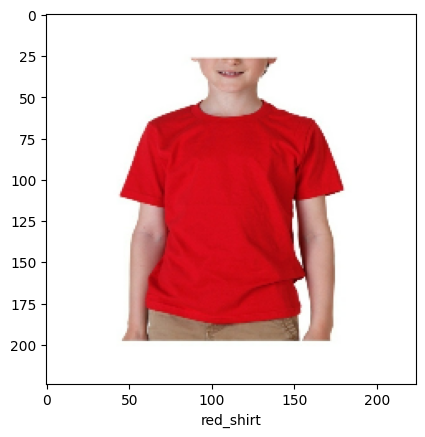

In [23]:
image_path = all_image_paths[0]
label = all_image_labels[0]
plt.imshow((load_and_preprocess_image(image_path)+1)/2)  # 进行归一化处理，
plt.grid(False)
plt.xlabel(label)

## tensorflow数据处理

In [24]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)#这里加载所有路径的图像

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image,
                       num_parallel_calls=AUTOTUNE)  #这里通过map方法对路径中每隔图像通过回调函数进行处理

In [26]:
image_ds

<_ParallelMapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>

In [27]:
label_ds = tf.data.Dataset.from_tensor_slices((color_labels, item_labels))

In [28]:
label_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [29]:
for ele in label_ds.take(3):
    print(ele[0].numpy(), ele[1].numpy())

0 0
0 1
0 0


In [30]:
# 组合data，label
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

{
  "image": tf.float32,
  "label": (tf.int32, tf.int32)
}

In [31]:
image_label_ds

<_ZipDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None)))>

In [32]:
test_count = int(image_count*0.2)
train_count = image_count-test_count

In [33]:
train_data = image_label_ds.take(train_count)
test_data = image_label_ds.take(test_count)

In [34]:
BATCH_SIZE = 32

In [35]:
# shuffle,repeat,batch
train_data = train_data.shuffle(buffer_size=train_count).repeat(-1)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)))>

In [36]:
test_data = test_data.batch(BATCH_SIZE)
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)))>

# 建立模型

In [52]:
mobile_net = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

In [ ]:
mobile_net.trainable=False

## 创建多输出模型

In [54]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = mobile_net(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [55]:
x1 = tf.keras.layers.Dense(1024, activation='relu')(x)
out_color = tf.keras.layers.Dense(3, 
                                  activation='softmax', 
                                  name='out_color')(x1)

In [56]:
x2 = tf.keras.layers.Dense(1024, activation='relu')(x)
out_item = tf.keras.layers.Dense(4, 
                                 activation='softmax', 
                                 name='out_item')(x2)

In [57]:
model = tf.keras.Model(inputs=inputs,
                       outputs=[out_color, out_item])

In [58]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['input_4[0][0]']             
 tional)                                                                                          
                                                                                                  
 global_average_pooling2d_1  (None, 1280)                 0         ['mobilenetv2_1.00_224[0][0]']
  (GlobalAveragePooling2D)                                                                        
                                                                                            

**利用回调函数自动调节学习速率**

In [59]:
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.8,min_lr=0.000001)

In [60]:
#根据神经网络名称来配置损失函数
model.compile(optimizer='adam',
                loss={'out_color': 'sparse_categorical_crossentropy',
                      'out_item': 'sparse_categorical_crossentropy'},
                metrics=['acc']
)

In [61]:
train_step=train_count//BATCH_SIZE
test_step=test_count//BATCH_SIZE

In [ ]:
history = model.fit(train_data,
                    epochs=20,
                    steps_per_epoch=train_step,
                    validation_data=test_data,
                    validation_batch_size=test_step,
                    callbacks=[lr_reduce],
                    verbose=2)

In [63]:
history.history.keys()

dict_keys(['loss', 'out_color_loss', 'out_item_loss', 'out_color_acc', 'out_item_acc', 'val_loss', 'val_out_color_loss', 'val_out_item_loss', 'val_out_color_acc', 'val_out_item_acc', 'lr'])

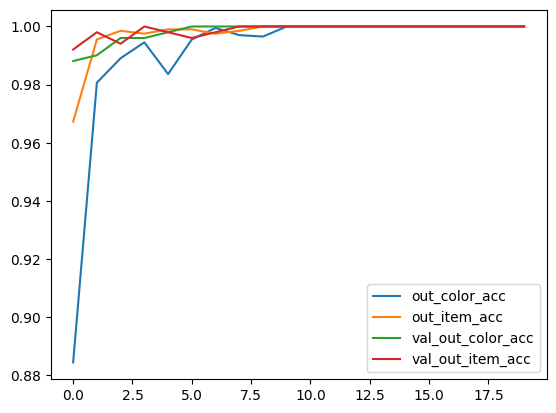

In [64]:
plt.plot(history.epoch,history.history.get('out_color_acc'),label='out_color_acc')
plt.plot(history.epoch,history.history.get('out_item_acc'),label='out_item_acc')
plt.plot(history.epoch,history.history.get('val_out_color_acc'),label='val_out_color_acc')
plt.plot(history.epoch,history.history.get('val_out_item_acc'),label='val_out_item_acc')
plt.legend()

---

In [ ]:
#测试模型输出
model.evaluate(test_data,verbose=0)

In [ ]:
my_image=tf.io.read_file('{}'.format(random.choice(all_image_paths)))#随便读入一个图片
my_image=tf.io.decode_jpeg(my_image,channels=3)
my_image=tf.image.resize(my_image,(224,224))
my_image=tf.cast(my_image,tf.float32)
my_image=my_image/255.0

plt.imshow(my_image)

**注意下面操作，将image形状改变，使其符合tensorflow网络要求**

In [ ]:
my_image=np.expand_dims(my_image,0)

In [ ]:
pre=model.predict(my_image)

In [ ]:
np.argmax(pre[0]),np.argmax(pre[1])

In [ ]:
color_label_names,item_label_names

In [ ]:
pre_color=(np.argmax(pre[0]))
list(color_label_names)[pre_color]

In [ ]:
pre_item=np.argmax(pre[1][0])
list(item_label_names)[pre_item]

In [ ]:
pre=model(my_image)

In [ ]:
pre_color=(np.argmax(pre[0]))
list(color_label_names)[pre_color]

In [ ]:
pre_item=np.argmax(pre[1][0])
list(item_label_names)[pre_item]

In [65]:
def test():
    path=random.choice(all_image_paths)
    print(path)
    my_image=tf.io.read_file('{}'.format(path))#随便读入一个图片
    my_image=tf.io.decode_jpeg(my_image,channels=3)
    my_image=tf.image.resize(my_image,(224,224))
    my_image=tf.cast(my_image,tf.float32)
    my_image=my_image/255.0
    
    plt.imshow(my_image)
    my_image=np.expand_dims(my_image,0)#扩充维度
    pre=model(my_image)#模型检测
    pre_color=(np.argmax(pre[0]))
    cl=list(color_label_names)[pre_color]
    
    pre_item=np.argmax(pre[1][0])
    it=list(item_label_names)[pre_item]
    print(cl,it)

/home/jhr/Documents/data/mov/dataset/black_shoes/00000078.jpg
black shoes


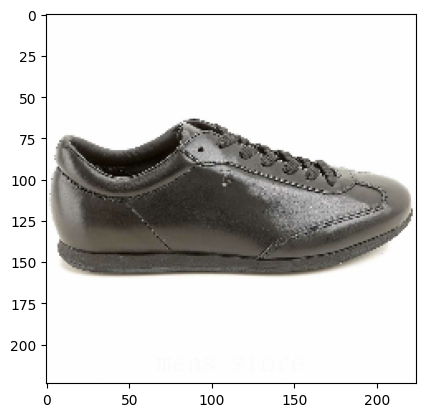

In [91]:
test()